# Plot Footprint With Points

In [1]:
import pandas as pd
import numpy as np
import sys
import configparser
import geopandas as gpd
import shapely
from fluxdataqaqc import Data, QaQc, Plot
from pyproj import Transformer
import matplotlib.pyplot as plt

from scipy import stats
import xarray as xr
from scipy.stats import gaussian_kde
import rasterio
from rasterio.transform import from_origin
#from bokeh.io import output_notebook
#output_notebook()

In [2]:
#sys.path.append("//")
sys.path.append("../../src")
import fluxfootprints
%matplotlib inline

In [ ]:

EPSG = 5070
# load initial flux data
station = 'US-UTE'
config_path = f'{station}.ini'
config = configparser.ConfigParser()
config.read(config_path)

#station = 'US-UTW'
stat_configs = fluxfootprints.load_configs(station,
                                     config_path='.',
                                     secrets_path="../../secrets/config.ini")

df = fluxfootprints.fetch_and_preprocess_data(stat_configs['url'], station, startdate='2022-01-01',)

d = Data(config_path)
d.df.index.freq = '30min'
df = d.df.rename(columns=d.inv_map)
q = QaQc(d, daily_frac=3/4, max_interp_hours=4, max_interp_hours_night=6)

# make copies of daily results of different correction options
q.correct_data(meth='ebr', et_gap_fill=True)
ebr_gapfilled = q.df


latitude = config['METADATA']['station_latitude']
longitude = config['METADATA']['station_longitude']

# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG}", always_xy=True)

# Perform the transformation
station_x, station_y = transformer.transform(longitude, latitude)

print(f"Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X={station_x}, Y={station_y}")

Failed to fetch data for station US-UTE: 401 Client Error: Unauthorized for url: https://ugs-koop-umfdxaxiyq-wm.a.run.app/amfluxeddy?stationid=eq.US-UTE&datetime_start=gte.2022-01-01
Calculating mean for var: THETA from columns: ['SWC_1_1_1', 'SWC_2_1_1']
Converting vpd from hpa to kpa
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure

The input data temporal frequency appears to be less than daily.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 6 hours when Rn < 0 and up to 4 hours when Rn >= 0.


c:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Filtering days with less then 75.0% or 36/48 sub-daily measurements
gridMET reference ET already downloaded for station at:
US-UTE_37.7333N_-111.5583W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)
Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X=-1353156.22180492, Y=1744260.286299747


In [18]:
data = pd.read_csv(config['METADATA']['climate_file_path'],
                   skiprows=int(config['METADATA']['skiprows']))
data['datetime_start'] = pd.to_datetime(data['datetime_start'])
data = data[(data['datetime_start'].dt.hour >= 6)&(data['datetime_start'].dt.hour <= 18)]

In [19]:
foot_xy = {}


#df = pd.read_csv("../../station_data/US-CdM_HH_202306141100_202410081700.csv")
for col in data.columns:
    if "fetch" in col.lower():
        data = fluxfootprints.polar_to_cartesian_dataframe(data, wd_column='WD',dist_column=col)

        data[f'X_{col}'] = data[f'X_{col}'] + station_x
        data[f'Y_{col}'] = data[f'Y_{col}'] + station_y

        foot_xy[col] = fluxfootprints.aggregate_to_daily_centroid(data,'datetime_start',f'X_{col}',f'Y_{col}',weighted=True)

daily_pnts = foot_xy['FETCH_55']
daily_pnts['geometry'] = gpd.points_from_xy(daily_pnts['X_FETCH_55'],
                                      daily_pnts['Y_FETCH_55'])
daily_pnts['date'] = pd.to_datetime(daily_pnts['Date'])
daily_pnts.drop(columns='Date', inplace=True)
daily_pnts.set_index('date', inplace=True)
daily_pnts = pd.concat([ebr_gapfilled, daily_pnts], axis=1)
daily_pnts_geo = gpd.GeoDataFrame(daily_pnts, geometry=daily_pnts.geometry)

data['ETpos'] = np.where(data['ET']>=0,data['ET'],np.nan)
#
data = data.set_index('datetime_start')

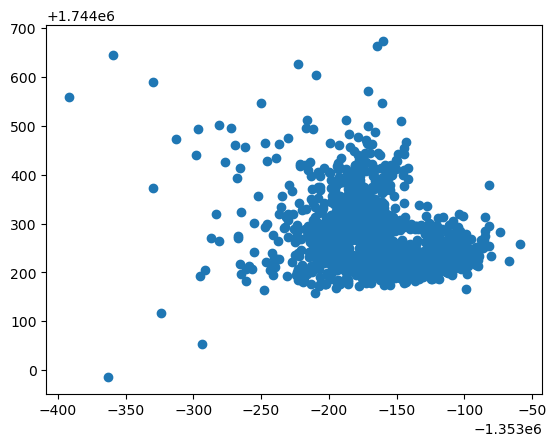

In [ ]:

plt.scatter(data['X_FETCH_55'],data['Y_FETCH_55'])

In [ ]:


epsg = 5070

gdf_day, gdf = fluxfootprints.concat_fetch_gdf(data,epsg=epsg)

res = 100

# List to hold KDE results for each day
kde_results = []

xmin = gdf.x.min()
xmax = gdf.x.max()
ymin = gdf.y.min()
ymax = gdf.y.max()

# Step 1: Create 2D grid
xvals = np.linspace(xmin, xmax, res)  # X range
yvals = np.linspace(ymin, ymax, res)  # Y range

X, Y = np.meshgrid(xvals, yvals)
positions = np.vstack([X.ravel(), Y.ravel()])

for day in gdf_day.index.date:
    hf_hr = gdf[gdf.index.date == day]
    m1 = hf_hr['x']
    m2 = hf_hr['y']

    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values, weights=hf_hr['weights'])
    Z = np.reshape(kernel(positions).T, X.shape)

    # Step 3: Compute 90th percentile threshold
    threshold_90 = np.percentile(Z, 90)

    # Step 4: Apply mask (set values > 90th percentile to NaN)
    Z_masked = np.where(Z > threshold_90, Z, np.nan)

    # Step 5: Normalize the masked values
    valid_sum = np.nansum(Z_masked)  # Sum only valid (non-NaN) values
    if valid_sum > 0:
        Z_normalized = Z_masked / valid_sum  # Normalize
    else:
        Z_normalized = Z_masked  # Avoid division by zero

    # Step 6: Create an xarray DataArray with georeferencing
    kde_da = xr.DataArray(
        Z_masked[:, :, np.newaxis],
        coords={'X': xvals,
                'Y': yvals,
                'time': [day],
                },  # Adjust for your coordinate system
        dims=['Y', 'X', 'time'],
        name='KDE',
    )

    # Optional: Assign CRS (WGS 84 for example)

    kde_da.attrs['crs'] = rasterio.crs.CRS.from_epsg(epsg)

    # Append the result to the list
    kde_results.append(kde_da)

# Concatenate all the daily KDE results along a new 'time' dimension
kde_da_all = xr.concat(kde_results, dim='time')

# Now 'kde_da_all' contains KDE results for each day, with 'time' as the new dimension
print(kde_da_all)


In [ ]:
import datetime
kde_da_all.sel(time=datetime.date(2021, 8, 30)).plot()

In [ ]:


# Example: List of dates (could be strings or datetime objects)
dates = ['2025-02-01', '2025-02-02', '2025-02-03']

# Example: Generate some random data points for each day (replace with actual data)
# For simplicity, we'll use random data; in your case, you would load the actual points for each day.
data_per_day = [np.random.randn(2, 1000) for _ in dates]

# Example grid for KDE (same grid for each day)
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
grid_x, grid_y = np.meshgrid(x, y)

# List to hold KDE results for each day
kde_results = []

# Loop over each day's data
for day, data in zip(dates, data_per_day):
    # Fit the KDE to the data for the day
    kde = gaussian_kde(data)
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()])
    kde_values = kde(grid_points).reshape(grid_x.shape)

    # Create a DataArray for the day and add it to the list
    kde_da_day = xr.DataArray(
        kde_values,
        coords=[('latitude', y), ('longitude', x), ],
        dims=['latitude', 'longitude'],
        name='KDE',
        attrs={'time': day}  # Add the time (or date) as an attribute
    )

    # Append the result to the list
    kde_results.append(kde_da_day)

# Concatenate all the daily KDE results along a new 'time' dimension
kde_da_all = xr.concat(kde_results, dim='time')

# Now 'kde_da_all' contains KDE results for each day, with 'time' as the new dimension
print(kde_da_all)


In [ ]:
gdf.dropna().plot()#.plot()

In [ ]:


m1 = gdf['x']
m2 = gdf['y']

xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)


fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()


In [ ]:


data = data.dropna(subset=['X_FETCH_90',
                           'Y_FETCH_90',
                           'X_FETCH_55',
                           'Y_FETCH_55',
                           'X_FETCH_40',
                           'Y_FETCH_40'],
                   how='any')

xs = np.concatenate((data['X_FETCH_90'].values, data['X_FETCH_55'].values, data['X_FETCH_40'].values))
ys = np.concatenate((data['Y_FETCH_90'].values,  data['Y_FETCH_55'].values,  data['Y_FETCH_40'].values))
weights = np.concatenate(([90]*len(data['X_FETCH_90']),
                    [55]*len(data['X_FETCH_55']),
                    [40]*len(data['X_FETCH_40'])))


#buffer_distance = 0
resolution = 50

# Define raster extent with buffer
xmin = np.min(xs)
ymin = np.min(ys)
xmax = np.max(xs)
ymax = np.max(ys)

# Create a mesh grid
xgrid = np.arange(xmin, xmax, resolution)
ygrid = np.arange(ymin, ymax, resolution)
xmesh, ymesh = np.meshgrid(xgrid, ygrid)

# Perform KDE with weights
kde = gaussian_kde(np.vstack([xs, ys]), weights=weights)
density = kde(np.vstack([xmesh.ravel(), ymesh.ravel()])).reshape(xmesh.shape)

# Normalize to ensure sum of cell values is 1
#print(np.sum(density))
#density /= np.sum(density)

# Define raster transform
transform = from_origin(xmin, ymax, resolution, resolution)

In [ ]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

data['geometry'] = gpd.points_from_xy(data['X_FETCH_55'],
                                      data['Y_FETCH_55'])

data_geo = gpd.GeoDataFrame(data, geometry=data.geometry, crs='EPSG:5070')
data_geo = data_geo.dropna(subset=['geometry','ETimp','X_FETCH_55','Y_FETCH_55'],how='any')

densitynorm = density / np.sum(density)

# Get raster bounds
xmin, ymax = transform.c, transform.f  # Top-left corner
res = transform.a  # Cell size
xmax = xmin + (density.shape[1] * res)
ymin = ymax - (density.shape[0] * res)

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the density raster
extent = [xmin, xmax, ymin, ymax]  # (left, right, bottom, top)
im = ax.imshow(densitynorm, extent=extent, origin="upper", cmap="viridis", alpha=0.7)
data_geo.plot(ax=ax, color="red", markersize=10, alpha=0.3, edgecolor="black")
print(extent)

# Add colorbar and labels
cbar = plt.colorbar(im, ax=ax, label="Normalized Density")
ax.set_title("Density Raster")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")


ax.scatter(station_x, station_y,color='red')
plt.xlim(xmin+5500, xmax-5500)
plt.ylim(ymin+6500, ymax-6500)

In [ ]:
# df = pd.read_csv('evapotranspiration_data.csv', parse_dates=['datetime'], index_col='datetime')
data = impute_evapotranspiration(data,in_field='ETpos',out_field='ETimp')
#df_imputed = imputer.impute(method="seasonal_median")
data['ETimp'].plot()

In [ ]:
from scipy.stats import gaussian_kde

data['geometry'] = gpd.points_from_xy(data['X_FETCH_55'],
                                      data['Y_FETCH_55'])

data_geo = gpd.GeoDataFrame(data, geometry=data.geometry, crs='EPSG:5070')
data_geo = data_geo.dropna(subset=['geometry','ETimp','X_FETCH_55','Y_FETCH_55'],how='any')

density, transform, (xmin, ymin, xmax, ymax) = plot_density_raster.generate_density_raster(data_geo,
                                                                                resolution=10,
                                                                                buffer_distance=10,
                                                                                weight_field='ETimp')

In [ ]:
fig, ax = fluxfootprints.plot_density_raster(density,transform,data_geo,show_points=False)
ax.scatter(station_x, station_y,color='red')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(density)

In [ ]:
daily_pnts.dropna(subset=['X_FETCH_55', 'ET'], inplace=True)
daily_pnts

In [ ]:
# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:5070", f"EPSG:4326", always_xy=True)

for ind in daily_pnts.index:

    # Perform the transformation
    longitude, latitude = transformer.transform(f"{daily_pnts.loc[ind, 'X_FETCH_55']}",
                                                 f"{daily_pnts.loc[ind, 'Y_FETCH_55']}")

    print(longitude, latitude)
    #(EPSG:5070)



In [ ]:
import requests

keyconf_path = f'../../secrets/config.ini'
keyconf = configparser.ConfigParser()
keyconf.read(keyconf_path)

# set your API key before making the request
header = {"Authorization": keyconf['OPENET']['key']}

# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:5070", f"EPSG:4326", always_xy=True)


oet = {}
i = 0
for ind in daily_pnts.index[:]:

    # Perform the transformation
    longitude, latitude = transformer.transform(f"{daily_pnts.loc[ind, 'X_FETCH_55']}",
                                                 f"{daily_pnts.loc[ind, 'Y_FETCH_55']}")

    print(longitude, latitude)


    args = {
      "date_range": [
        f"{ind:%Y-%m-%d}",
        f"{ind+pd.Timedelta(days=1):%Y-%m-%d}"
      ],
      "file_format": "JSON",
      "geometry": [
        -121.36322,
        38.87626
      ],
      "interval": "daily",
      "model": "Ensemble",
      "reference_et": "gridMET",
      "units": "mm",
      "variable": "ET"
    }

    # query the api
    resp = requests.post(
        headers=header,
        json=args,
        url="https://openet-api.org/raster/timeseries/point"
    )

    if resp.status_code != 200:
        pass
    else:
        print(resp.json(),i)
        oet[ind] = resp.json()[0]['et']
    i+=1

In [ ]:
config = configparser.ConfigParser()

config.read('../../secrets/config.ini')

from sqlalchemy import create_engine
import urllib.parse
host = config['DEFAULT']['ip']
pw = config['DEFAULT']['pw']
user = config['DEFAULT']['login']

encoded_password = urllib.parse.quote_plus(pw)

def postconn_et(encoded_password, host='localhost',user='postgres',port='5432',db='groundwater', schema = 'groundwater'):
    connection_text = "postgresql+psycopg2://{:}:{:}@{:}:{:}/{:}?gssencmode=disable".format(user,encoded_password,host,port,db)
    return create_engine(connection_text, connect_args={'options': '-csearch_path={}'.format(schema)})


engine = postconn_et(encoded_password, host=host, user=user)

In [ ]:
from psycopg2.extensions import register_adapter, AsIs
import numpy as np
def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)
def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)
register_adapter(np.float64, addapt_numpy_float64)
register_adapter(np.int64, addapt_numpy_int64)

In [ ]:
daily_pnts['openet_ens_mm'] = daily_pnts.index.map(oet)
daily_pnts['stationid'] = 'US-UTM'
daily_pnts_no_geo = daily_pnts.drop(['geometry'], axis=1)
daily_pnts_no_geo.to_parquet("G:/Shared drives/UGS_Flux/Data_Processing/Wellington/daily_footprint_pnts_utm.parquet")
daily_pnts_no_geo.to_sql('daily_et',engine,if_exists='append', index=False)


In [ ]:
daily_pnts_geo.index

In [ ]:
daily_pnts = pd.read_parquet("G:/Shared drives/UGS_Flux/Data_Processing/Wellington/daily_footprint_pnts_utm.parquet")


In [ ]:
daily_pnts['openet_ens_mm'] = daily_pnts.index.map(oet)
daily_pnts['stationid'] = 'US-UTW'

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(daily_pnts['ET_fill'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()


In [ ]:
plt.scatter(daily_pnts['ET_corr'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()

In [ ]:
plt.scatter(daily_pnts['ET'],daily_pnts['openet_ens_mm'])
xline = np.linspace(0,18,100)
plt.plot(xline,xline)
plt.grid()

In [ ]:
plt.plot(daily_pnts.index,daily_pnts['ET'],label='Measured ET')
plt.plot(daily_pnts.index,daily_pnts['openet_ens_mm'],label='OpenET ET')
plt.legend()

In [ ]:
url = "https://services1.arcgis.com/99lidPhWCzftIe9K/arcgis/rest/services/WaterRelatedLandUse/FeatureServer/0/query?where=1%3D1&outFields=*&geometry=-110.75%2C39.438%2C-110.710%2C39.45&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&outSR=5070&f=json"

well_fields = gpd.read_file(url)
well_fields = well_fields[well_fields['OBJECTID'].isin([53384,57425])]
well_fields.plot()

In [ ]:
# Get the extent of the shapefile
total_bounds = well_fields.total_bounds

# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = 20
while y <= maxY:
    while x <= maxX:
        geom = shapely.geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:5070')
#fishnet.to_file('fishnet_grid.shp')

In [ ]:


# Create a geometry column
df['geometry'] = gpd.points_from_xy(df['X_FETCH_55'], df['Y_FETCH_55'])
df['geometry'].unique()
# Convert the DataFrame to a GeoDataFrame
#gdf = gpd.GeoDataFrame(df, geometry='geometry')